# Compare synthetic forecasts from model fit to real GCM forecasts

To do:
- Check what your forecasts look like relative to real forecasts
- Try fitting to hindcast winter NAO index
- Trend in one signal and trend in both signals

In [1]:
import cftime

import numpy as np

import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

import dask
dask.config.set(**{"array.slicing.split_large_chunks": False})

from src import utils, plot, stats, ar_model

In [54]:
DATA_DIR = "../../data/processed"

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["axes.grid"] = True

## Boreal winter (December to March) NAO indices

In [161]:
HadGEM3 = (
    xr.open_zarr(f"{DATA_DIR}/psl_Amon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True)
    / 100
)
NAO_HadGEM3 = utils.calculate_period_NAO_index(
    HadGEM3["psl"],
    [12, 1, 2, 3],
).compute()
NAO_HadGEM3 = NAO_HadGEM3.isel(lead=slice(1, None))  # Drop first lead

In [162]:
ECEarth3 = (
    xr.open_zarr(f"{DATA_DIR}/psl_Amon_EC-Earth3_dcpp.zarr", use_cftime=True) / 100
)
NAO_ECEarth3 = utils.calculate_period_NAO_index(
    ECEarth3["psl"],
    [12, 1, 2, 3],
).compute()
NAO_ECEarth3 = NAO_ECEarth3.isel(lead=slice(1, None))  # Drop first lead

In [163]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO_HadSLP = utils.calculate_period_NAO_index(
    HadSLP["slp"],
    [12, 1, 2, 3],
).compute()

### Fit an AR model

In [198]:
input_data = NAO_HadSLP

res = ar_model.fit(
    input_data,
    order="select_order",
)
params = res[:-1].values
scale = res[-1].values

### Generate some synthetic forecasts

In [199]:
inits = ar_model.generate_samples(
    params=params,
    scale=scale,
    n_times=NAO_HadGEM3.sizes["init"],
    n_samples=1,
)

In [206]:
NAO_synthetic = ar_model.predict(
    params=params,
    inits=inits,
    n_steps=NAO_HadGEM3.sizes["lead"],
    n_members=NAO_HadGEM3.sizes["member"],
    scale=scale,
)

NAO_synthetic = NAO_synthetic.assign_coords(
    {"time": NAO_synthetic.init + NAO_synthetic.lead}
)

### How do the synthetic forecasts compare to the real forecasts?

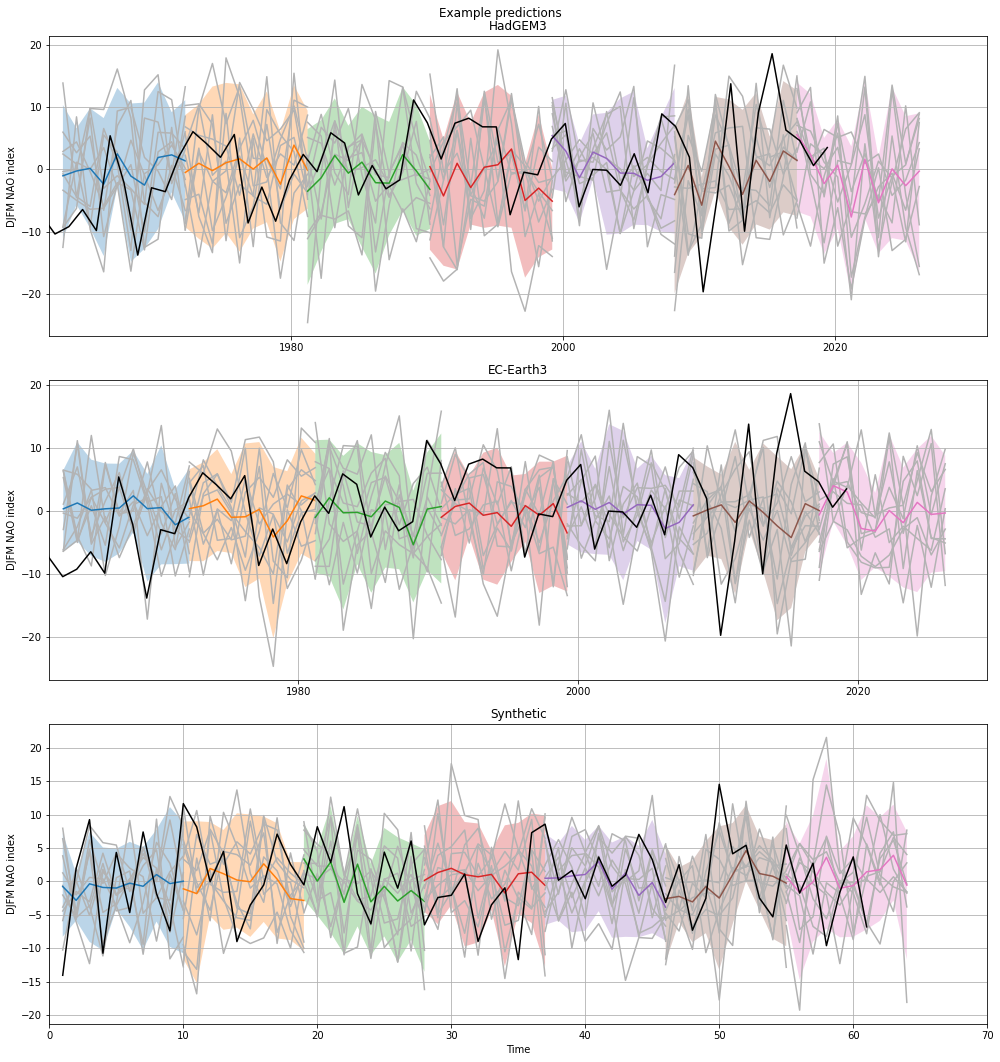

In [207]:
to_plot = {
    "HadGEM3": (NAO_HadGEM3, NAO_HadSLP),
    "EC-Earth3": (NAO_ECEarth3, NAO_HadSLP),
    "Synthetic": (NAO_synthetic, inits),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, (fcst, init)) in enumerate(to_plot.items()):
    ax = axs[i]

    for i in fcst.init[1::9]:
        fcst_plot = fcst.sel(init=i)
        ax.fill_between(
            fcst_plot.time.values,
            fcst_plot.quantile(0.05, dim="member"),
            fcst_plot.quantile(0.95, dim="member"),
            edgecolor="none",
            alpha=0.3,
        )
        for m in fcst_plot.member:
            ax.plot(
                fcst_plot.time.values, fcst_plot.sel(member=m), color=[0.7, 0.7, 0.7]
            )
        ax.plot(
            fcst_plot.time.values,
            fcst_plot.mean("member"),
        )
        ax.set_title(name)
    ax.set_xlim(fcst.time.min().item(), fcst.time.max().item())
    ax.set_ylabel("DJFM NAO index")

    ax.plot(init.time, init, color="k")

ax.set_xlabel("Time")
fig.suptitle("Example predictions")
fig.tight_layout()

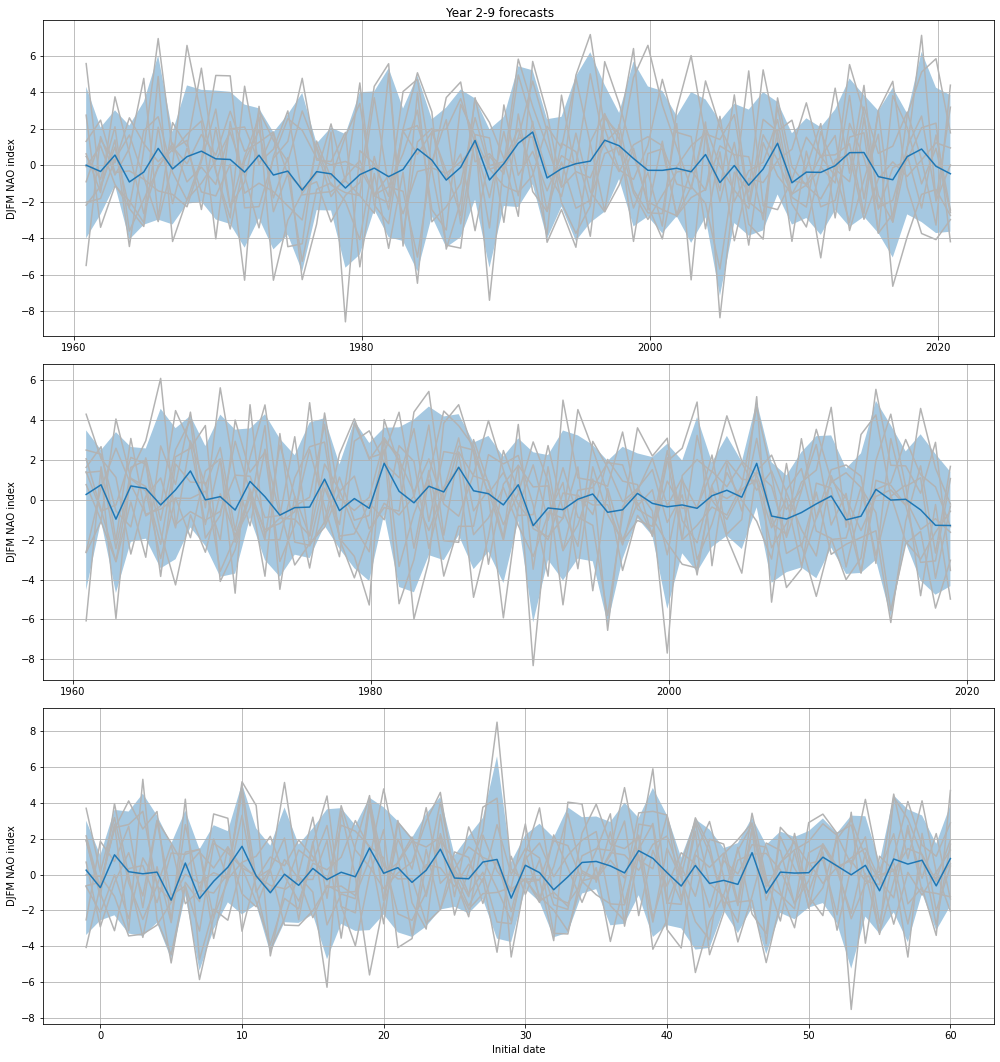

In [208]:
avg = (0, 8)

to_plot = {
    "HadGEM3": NAO_HadGEM3.isel(lead=slice(*avg)).mean("lead"),
    "EC-Earth3": NAO_ECEarth3.isel(lead=slice(*avg)).mean("lead"),
    "Synthetic": NAO_synthetic.isel(lead=slice(*avg)).mean("lead"),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, fcst) in enumerate(to_plot.items()):
    ax = axs[i]

    ax.fill_between(
        fcst.init.values,
        fcst.quantile(0.05, dim="member"),
        fcst.quantile(0.95, dim="member"),
        edgecolor="none",
        alpha=0.4,
    )
    for m in fcst.member:
        ax.plot(fcst.init.values, fcst.sel(member=m), color=[0.7, 0.7, 0.7])
    ax.plot(
        fcst.init.values,
        fcst.mean("member"),
    )
    ax.set_title("")  # name)
    ax.set_ylabel("DJFM NAO index")

ax.set_xlabel("Initial date")
fig.suptitle("Year 2-9 forecasts")
fig.tight_layout()

## Boreal winter (December to March) AMV indices

In [76]:
HadGEM3["tos"] = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True
)["tos"]
AMV_HadGEM3 = utils.calculate_period_AMV_index(
    HadGEM3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_HadGEM3 = AMV_HadGEM3.isel(lead=slice(1, None))  # Drop first lead

In [77]:
ECEarth3["tos"] = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_EC-Earth3_dcpp.zarr", use_cftime=True
)["tos"]
AMV_ECEarth3 = utils.calculate_period_AMV_index(
    ECEarth3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_ECEarth3 = AMV_ECEarth3.isel(lead=slice(1, None))  # Drop first lead

In [135]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV_HadISST = utils.calculate_period_AMV_index(
    HadISST["sst"],
    [12, 1, 2, 3],
).compute()

### Fit an AR model

In [160]:
input_data = AMV_HadISST

res = ar_model.fit(
    input_data,
    order="select_order",
    select_order_kwargs={"maxlag": 10, "ic": "aic", "glob": False, "trend": "n"},
)
params = res[:-1].values
scale = res[-1].values

### Generate some synthetic forecasts

In [ ]:
ar_select_order(data, maxlag, **kwargs)

In [150]:
inits = ar_model.generate_samples(
    params=params,
    scale=scale,
    n_times=AMV_HadGEM3.sizes["init"],
    n_samples=1,
)

In [151]:
AMV_synthetic = ar_model.predict(
    params=params,
    inits=inits,
    n_steps=AMV_HadGEM3.sizes["lead"],
    n_members=AMV_HadGEM3.sizes["member"],
    scale=scale,
)

AMV_synthetic = AMV_synthetic.assign_coords(
    {"time": AMV_synthetic.init + AMV_synthetic.lead}
)

### How do the synthetic forecasts compare to the real forecasts?

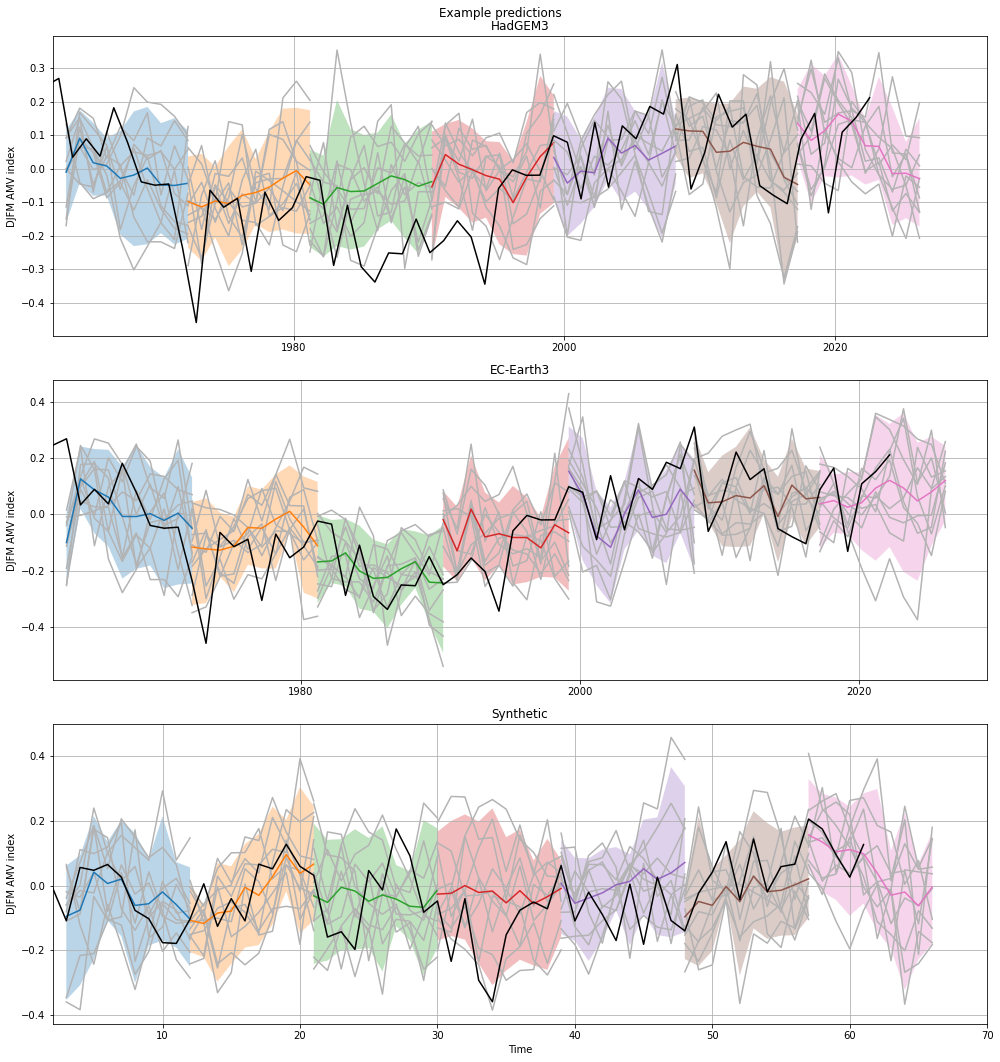

In [152]:
to_plot = {
    "HadGEM3": (AMV_HadGEM3, AMV_HadISST),
    "EC-Earth3": (AMV_ECEarth3, AMV_HadISST),
    "Synthetic": (AMV_synthetic, inits),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, (fcst, init)) in enumerate(to_plot.items()):
    ax = axs[i]

    for i in fcst.init[1::9]:
        fcst_plot = fcst.sel(init=i)
        ax.fill_between(
            fcst_plot.time.values,
            fcst_plot.quantile(0.05, dim="member"),
            fcst_plot.quantile(0.95, dim="member"),
            edgecolor="none",
            alpha=0.3,
        )
        for m in fcst_plot.member:
            ax.plot(
                fcst_plot.time.values, fcst_plot.sel(member=m), color=[0.7, 0.7, 0.7]
            )
        ax.plot(
            fcst_plot.time.values,
            fcst_plot.mean("member"),
        )
        ax.set_title(name)
    ax.set_xlim(fcst.time.min().item(), fcst.time.max().item())
    ax.set_ylabel("DJFM AMV index")

    ax.plot(init.time, init, color="k")

ax.set_xlabel("Time")
fig.suptitle("Example predictions")
fig.tight_layout()

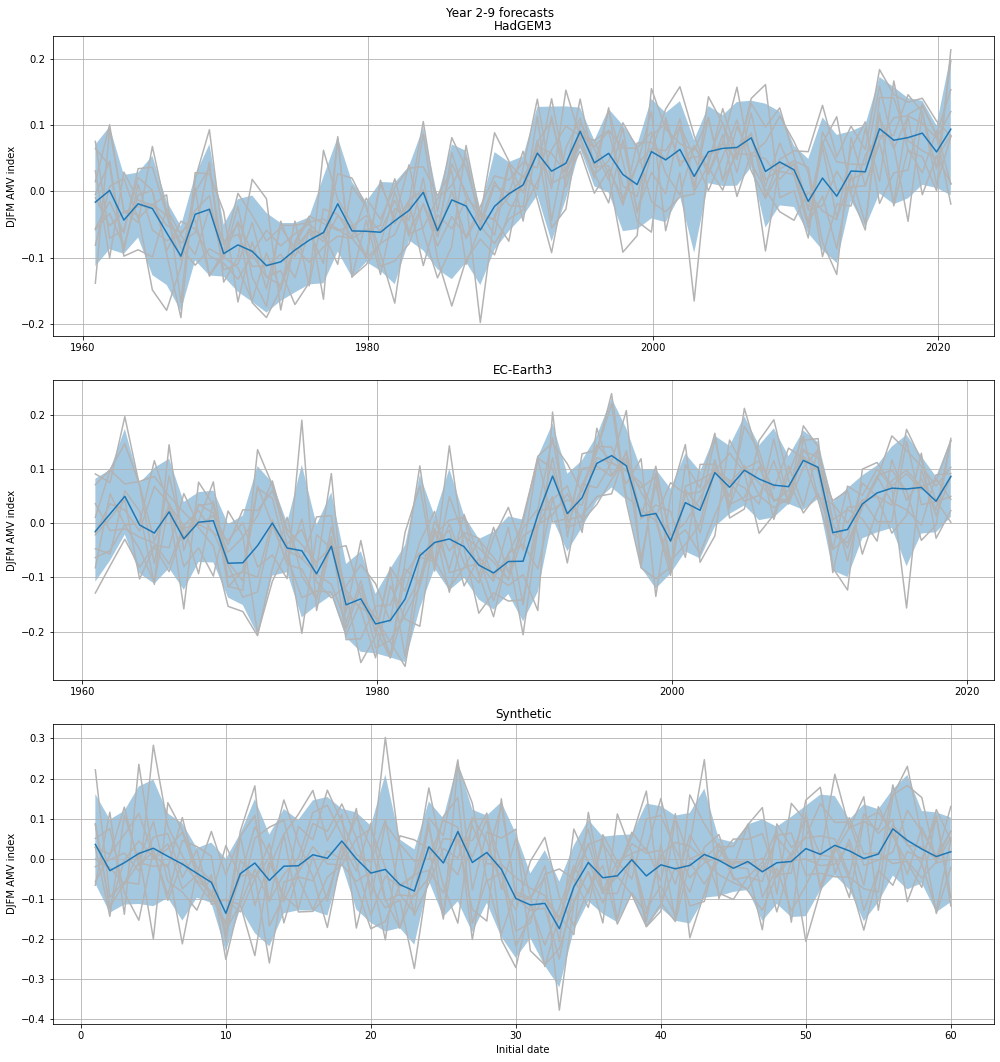

In [153]:
avg = (0, 8)

to_plot = {
    "HadGEM3": AMV_HadGEM3.isel(lead=slice(*avg)).mean("lead"),
    "EC-Earth3": AMV_ECEarth3.isel(lead=slice(*avg)).mean("lead"),
    "Synthetic": AMV_synthetic.isel(lead=slice(*avg)).mean("lead"),
}

nrows = len(to_plot)
fig = plt.figure(figsize=(14, 5 * nrows))
axs = fig.subplots(nrows, 1)

for i, (name, fcst) in enumerate(to_plot.items()):
    ax = axs[i]

    ax.fill_between(
        fcst.init.values,
        fcst.quantile(0.05, dim="member"),
        fcst.quantile(0.95, dim="member"),
        edgecolor="none",
        alpha=0.4,
    )
    for m in fcst.member:
        ax.plot(fcst.init.values, fcst.sel(member=m), color=[0.7, 0.7, 0.7])
    ax.plot(
        fcst.init.values,
        fcst.mean("member"),
    )
    ax.set_title(name)
    ax.set_ylabel("DJFM AMV index")

ax.set_xlabel("Initial date")
fig.suptitle("Year 2-9 forecasts")
fig.tight_layout()